In [24]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter
import numpy as np


In [25]:
RAW_IMAGE_FOLDER = r"F:\University\F1403\NNDL\Neural-Networks-and-Deep-Learning-Course-Projects-F2024\CA3\FullIJCNN2013"
ANNOTATIONS_FILE = r"F:\University\F1403\NNDL\Neural-Networks-and-Deep-Learning-Course-Projects-F2024\CA3\FullIJCNN2013\gt.txt"

# Mapping Class IDs to major categories
CLASS_TO_CATEGORY = {
    **dict.fromkeys(range(0, 11), "prohibitory"),  # ClassIDs 0-10
    **dict.fromkeys(range(11, 32), "danger"),      # ClassIDs 11-31
    **dict.fromkeys(range(33, 42), "mandatory"),   # ClassIDs 33-41
    **dict.fromkeys([6, 12, 13, 14, 17, 32, 41, 42], "other")  # Specific ClassIDs
}


In [26]:

class TrafficSignDataset(Dataset):
    def __init__(self, image_folder, annotations_file, transforms=None):
        self.image_folder = image_folder
        self.transforms = transforms

        self.annotations = np.genfromtxt(annotations_file, delimiter=';', dtype=None, encoding='utf-8')

        self.annotation_dict = {}
        for entry in self.annotations:
            img_name = entry[0]
            bbox = [float(entry[1]), float(entry[2]), float(entry[3]), float(entry[4])]
            label = int(entry[5])

            if img_name not in self.annotation_dict:
                self.annotation_dict[img_name] = []
            self.annotation_dict[img_name].append((bbox, label))

        self.img_names = sorted(self.annotation_dict.keys())

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.image_folder, img_name)

        img = Image.open(img_path).convert("RGB")

        # Get bounding boxes and labels for the image
        annotations = self.annotation_dict[img_name]
        boxes = [ann[0] for ann in annotations]
        labels = [ann[1] for ann in annotations]

        # Convert to tensors
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        # Additional target metadata
        image_id = torch.tensor([idx])
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.img_names)

In [27]:

def classify_bbox_sizes_and_classes(dataset):
    size_category_counts = {
        "small": {"prohibitory": 0, "mandatory": 0, "danger": 0, "other": 0},
        "medium": {"prohibitory": 0, "mandatory": 0, "danger": 0, "other": 0},
        "large": {"prohibitory": 0, "mandatory": 0, "danger": 0, "other": 0}
    }

    for _, target in dataset:
        boxes = target["boxes"]
        labels = target["labels"]

        for box, label in zip(boxes, labels):
            width = box[2] - box[0]
            # Determine size category
            if width < 32:
                size_group = "small"
            elif 32 <= width <= 45:
                size_group = "medium"
            else:
                size_group = "large"

            # Get major category for the class
            major_category = CLASS_TO_CATEGORY.get(label.item(), "other")
            size_category_counts[size_group][major_category] += 1

    return size_category_counts

def visualize_class_distribution(size_category_counts):
    categories = ["prohibitory", "mandatory", "danger", "other"]
    size_groups = ["small", "medium", "large"]
    width = 0.2  # Bar width
    x = np.arange(len(size_groups))  # X-axis positions

    # Prepare data for plotting
    bar_data = {cat: [size_category_counts[size][cat] for size in size_groups] for cat in categories}

    # Plot
    plt.figure(figsize=(12, 6))
    for i, category in enumerate(categories):
        plt.bar(x + i * width, bar_data[category], width, label=category)

    plt.title("Class Distribution by Size Category")
    plt.xlabel("Size Category")
    plt.ylabel("Frequency")
    plt.xticks(x + width * 1.5, size_groups)  # Center labels
    plt.legend(title="Class Group")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

def visualize_image_with_annotations(dataset, indices):
    for idx in indices:
        img, target = dataset[idx]

        img_np = np.array(img)

        fig, ax = plt.subplots(1)
        ax.imshow(img_np)

        for box, label in zip(target["boxes"].numpy(), target["labels"].numpy()):
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle(
                (xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none'
            )
            ax.add_patch(rect)
            ax.text(xmin, ymin - 5, f"Class {label}", color='green', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

        ax.set_title(f"Image: {dataset.img_names[idx]}")
        plt.show()

In [28]:

transforms = None
dataset = TrafficSignDataset(RAW_IMAGE_FOLDER, ANNOTATIONS_FILE, transforms=transforms)

print(f"Number of images: {len(dataset)}")



Number of images: 741


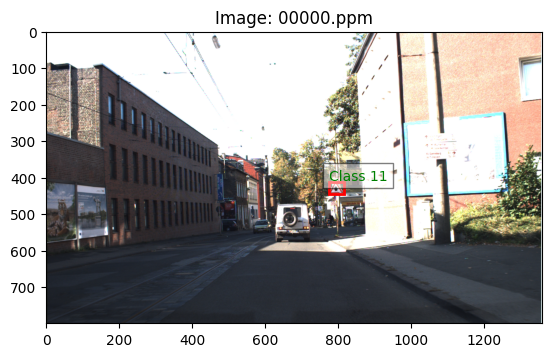

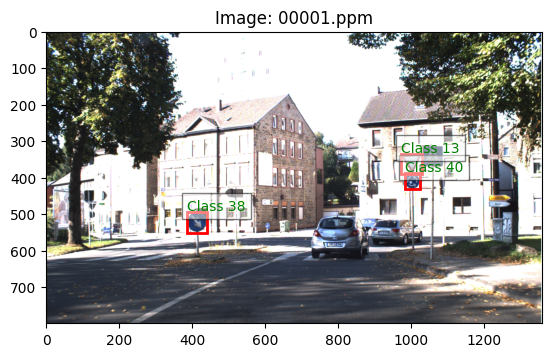

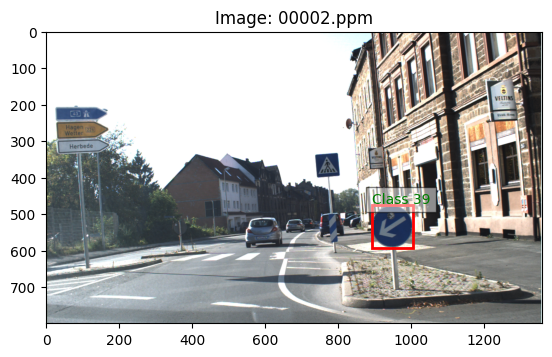

In [29]:
# Visualize images with annotations
visualize_image_with_annotations(dataset, indices=[0, 1, 2])



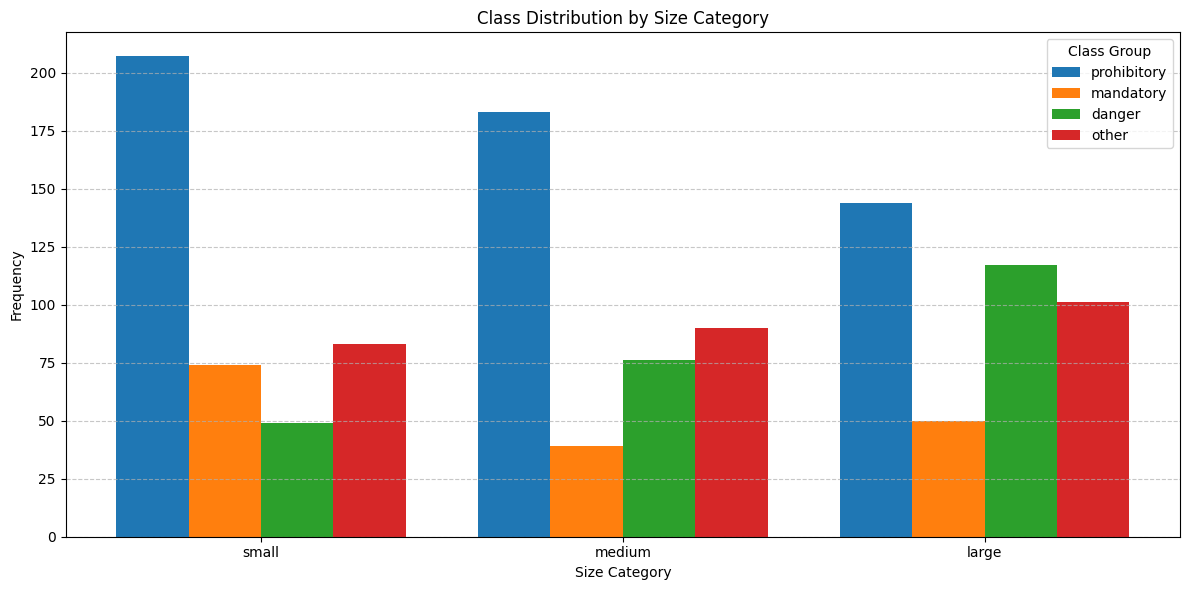

In [30]:
size_category_counts = classify_bbox_sizes_and_classes(dataset)

visualize_class_distribution(size_category_counts)

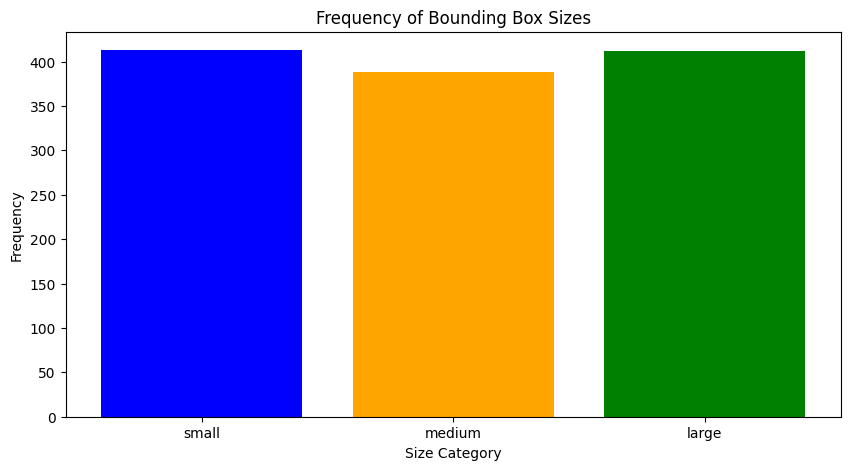

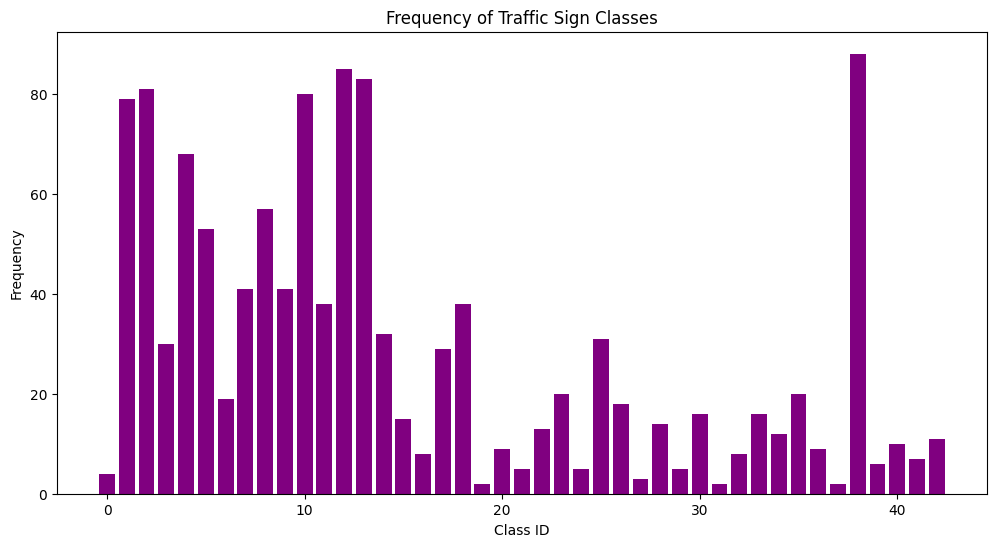

In [31]:
size_categories, class_frequencies = classify_bbox_sizes(dataset)

plt.figure(figsize=(10, 5))
plt.bar(size_categories.keys(), size_categories.values(), color=['blue', 'orange', 'green'])
plt.title("Frequency of Bounding Box Sizes")
plt.xlabel("Size Category")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(class_frequencies.keys(), class_frequencies.values(), color='purple')
plt.title("Frequency of Traffic Sign Classes")
plt.xlabel("Class ID")
plt.ylabel("Frequency")
plt.show()
